# Hyperparameter Optimization mit hyperas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from hyperopt import Trials, STATUS_OK, tpe

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


### Data preparation

In [2]:
def data():
    news = pd.read_csv('../data/mixed_news/news_dataset.csv')
    news = news.dropna(subset=['title','content'])
    news = news[news.content != ' ']
    news = news[news.title != ' ']
    with h5py.File('encoded_data/title_encode.h5', 'r') as hf:
        title_encode = hf['title_encode'][:]
    title_NN = pd.DataFrame(data = title_encode)
    x_train, x_test, y_train, y_test = train_test_split(title_NN,news.label, test_size=0.33, stratify=news.label,
                                                        random_state=42)
    LE = LabelEncoder()
    LE.fit(["fake","real"])
    y_train = LE.transform(y_train)
    y_test = LE.transform(y_test)
    return x_train, y_train, x_test, y_test

## Model creation

In [3]:
def create_model(x_train, y_train, x_test, y_test):
    dim = x_train.shape[1]
    model = Sequential()
    model.add(Dense({{choice([768,2*768,4*768])}}, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense({{choice([int(0.1*768), int(0.5*768), 768])}}))
        model.add(Dropout(0.5))
        
    model.add(Dense({{choice([10, 256, 512])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(1))
    model.add(Activation({{choice(['sigmoid','softmax'])}}))

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

    result = model.fit(x_train, y_train,
              batch_size={{choice([64, 128])}},
              epochs=10,
              verbose=2,
              validation_split=0.3,
              callbacks=[early_stop])
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

## Optimization with hyperopt
Algorithm: Tree of Parzen Estimators

In [33]:
trials = Trials()
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=50,
                                      trials=trials,
                                     notebook_name='Hyperopt')
X_train, Y_train, X_test, Y_test = data()
print("Best performing model chosen hyper-parameters:")
print(best_run)
best_model.save('../model/best_Hyperopt_NN_Bert.hdf5')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import h5py
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.metrics import roc_curve, auc
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, LeakyReLU, Activation
except:
    pass

try:
    from keras.callbacks import TensorBoard, ModelCheckpoint
except:
    pass

try:
    from keras.models import load_model
except:
    pass

try:
    from sklearn.metrics import confusion_matrix, classification_report
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from sklearn.preprocessing import LabelEncoder
except:
    pass

try:
    from keras.callbacks i

## Evaluation of best model

9201/9201 [==============================] - 1s 101us/step
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      4016
           1       0.75      0.87      0.80      5185

   micro avg       0.76      0.76      0.76      9201
   macro avg       0.77      0.75      0.75      9201
weighted avg       0.77      0.76      0.76      9201

[[2515 1501]
 [ 685 4500]]


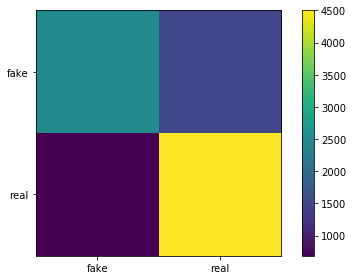

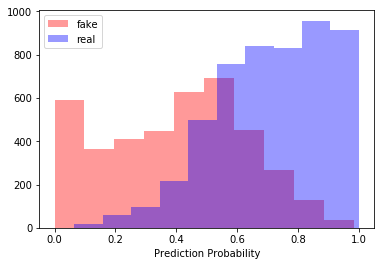

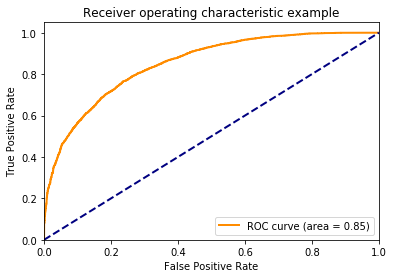

In [7]:
y_pred = best_model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.round(y_pred)
print(classification_report(Y_test, y_pred_bool))
print(confusion_matrix(Y_test, y_pred_bool,
                       labels=[0,1]))
plt.imshow(confusion_matrix(Y_test, y_pred_bool,
                            labels=[0,1]))
plt.tight_layout()
plt.colorbar()
plt.xticks(range(2), ["fake", "real"])
plt.yticks(range(2), ["fake", "real"])
plt.show()
plt.savefig("../build/plots/Bert/cnfsn_mtx_Hyperopt_bert_title_nn.pdf")
plt.close()

plt.hist(y_pred[Y_test == 0],label="fake", alpha = 0.4, color = "r")
plt.hist(y_pred[Y_test == 1],label = "real",alpha = 0.4, color = "b")
plt.xlabel("Prediction Probability")
plt.legend()
plt.show()
plt.savefig("../build/plots/Bert/prob_Hyperopt_bert_title_nn.pdf")
plt.close()

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.savefig("../build/plots/Bert/roc_Hyperopt_bert_title_nn.pdf")
plt.close()

In [55]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.6375802993604237,
   'status': 'ok',
   'model': <keras.engine.sequential.Sequential at 0x7faf4cbfa0f0>},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'Activation': [0],
    'Activation_1': [0],
    'Dense': [0],
    'Dense_1': [0],
    'Dense_2': [0],
    'Dropout': [0],
    'Dropout_1': [0],
    'Dropout_2': [0],
    'batch_size': [0],
    'optimizer': [0]},
   'vals': {'Activation': [1],
    'Activation_1': [0],
    'Dense': [2],
    'Dense_1': [2],
    'Dense_2': [1],
    'Dropout': [0.7342146978592597],
    'Dropout_1': [1],
    'Dropout_2': [0.6517968154887782],
    'batch_size': [1],
    'optimizer': [2]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2019, 6, 28, 11, 2, 3, 764000),
  'refresh_time': datetime.datetime(2019, 6, 28, 11, 2, 29, 513000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0